In [2]:
import pandas as pd
import geopandas as gp
import os

'''
Sources:
shp: https://www.nconemap.gov/datasets/voting-precincts/explore?location=35.097107%2C-79.888900%2C7.41
'''

In [3]:
gdf = gp.read_file("./raw-from-source/Voting_Precincts/Voting_Precincts.shp")

In [32]:
dfmedsl = pd.read_csv("./raw-from-source/NC-cleaned-final3.csv")

In [25]:
df = pd.read_table("./raw-from-source/results_pct_20221108 (1).zip", sep = "\t")

In [26]:
df

,County,Election Date,Precinct,Contest Group ID,Contest Type,Contest Name,Choice,Choice Party,Vote For,Election Day,One Stop,Absentee by Mail,Provisional,Total Votes,Real Precinct,Unnamed: 15
0,COLUMBUS,11/08/2022,P17,7,C,COLUMBUS COUNTY SCHOOLS BOARD OF EDUCATION DIS...,Timothy Lance,,1,136,159,7,1,303,Y,NaN
1,COLUMBUS,11/08/2022,P17,9,C,COLUMBUS COUNTY SCHOOLS BOARD OF EDUCATION DIS...,Chris Worley,,1,163,184,8,2,357,Y,NaN
2,COLUMBUS,11/08/2022,P17,1362,S,NC SUPREME COURT ASSOCIATE JUSTICE SEAT 03,Lucy Inman,DEM,1,147,247,7,2,403,Y,NaN
3,COLUMBUS,11/08/2022,P17,1363,S,NC SUPREME COURT ASSOCIATE JUSTICE SEAT 05,Sam J. Ervin IV,DEM,1,150,249,10,2,411,Y,NaN
4,COLUMBUS,11/08/2022,P19,11,C,WHITEVILLE CITY SCHOOLS BOARD OF EDUCATION DIS...,Write-In (Miscellaneous),NaN,1,3,2,0,0,5,Y,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171895,WAKE,11/08/2022,20-01,16,C,WAKE SOIL AND WATER CONSERVATION DISTRICT SUPE...,Alex Baldwin,,2,114,0,0,0,114,Y,NaN
171896,WAKE,11/08/2022,20-01,16,C,WAKE SOIL AND WATER CONSERVATION DISTRICT SUPE...,Paul Fitts (Write-In),NaN,2,0,0,0,0,0,Y,NaN
171897,WAKE,11/08/2022,20-01,16,C,WAKE SOIL AND WATER CONSERVATION DISTRICT SUPE...,Tara Waters (Write-In),NaN,2,0,0,0,0,0,Y,NaN
171898,WAKE,11/08/2022,20-01,29,C,WAKE COUNTY SCHOOL BONDS REFERENDUM,No,,1,246,0,0,0,246,Y,NaN


In [27]:
len(set(gdf.prec_id) - set(df['Precinct']))

12

In [28]:
len(set(df['Precinct'])-set(gdf.prec_id))

205

In [29]:
set(gdf.prec_id) - set(df['Precinct'])

{'0029-A',
 '0029-B',
 '0053',
 '0065',
 '507',
 'GN',
 'HM',
 'J',
 'MON119',
 'R1',
 'R2',
 'W18'}

In [30]:
set(df['Precinct'])-set(gdf.prec_id)

{'0071',
 '0072',
 '01-07A',
 '07-07A',
 '120A',
 'ABS',
 'ABSEN 1-40',
 'ABSEN 121-127',
 'ABSEN 41-80',
 'ABSEN 81-120',
 'ABSENTEE',
 'ABSENTEE 1',
 'ABSENTEE BY MAIL',
 'ABSENTEE MAIL',
 'ABSENTEE SUPPLEMENTAL',
 'CV',
 'DBOS',
 'GRF',
 'GSN',
 'HMT',
 'JMV',
 'LEE COUNTY BOE',
 'MAOS',
 'MCSWAIN CENTER',
 'MON113',
 'MT PLEASANT-OS',
 'NASHVILLE-OS',
 'ONE STOP',
 'ONE STOP 1',
 'ONE STOP 2',
 'ONE STOP 3',
 'ONE STOP 4',
 'ONE STOP BOE',
 'ONE STOP CB',
 'ONE STOP CFCC',
 'ONE STOP CFN',
 'ONE STOP DANBURY',
 'ONE STOP HOS',
 'ONE STOP KING',
 'ONE STOP NLB',
 'ONE STOP RESOURCE CENTER',
 'ONE STOP ROCKFISH',
 'ONE STOP SHUFORD REC',
 'ONE STOP SRC',
 'ONE STOP WALNUT COVE',
 'ONESTOP',
 'OS ADMIN',
 'OS AG CENTER',
 'OS ARCADIA',
 'OS ASU',
 'OS BERMUDA RUN',
 'OS BLOWING ROCK',
 'OS BOE',
 'OS CHL',
 'OS COMMUNITY SCH',
 'OS COTC',
 'OS COUNTY OFFICE',
 'OS CTH',
 'OS DCML',
 'OS DEEP GAP',
 'OS DENTON',
 'OS DUKE',
 'OS EA',
 'OS ENF',
 'OS ERC',
 'OS ERL',
 'OS ERUUF',
 'OS F

In [35]:
set(dfmedsl.precinct)-set(df.Precinct)

{'1.1',
 '2.1',
 '3.1',
 '4.1',
 '49',
 '5.1',
 '53',
 '55',
 '57',
 '59',
 '6.1',
 '67',
 '69',
 '7',
 '7.1',
 '71',
 '73',
 '77',
 '78.1',
 '79',
 '8',
 '8.2',
 '8.3',
 '80',
 '81',
 '83',
 '86',
 '87',
 '89',
 '9.1',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 'PEN\xa010.00'}

In [36]:
set(df.Precinct)-set(dfmedsl.precinct)

{'0001',
 '0003',
 '0007',
 '0008',
 '001',
 '0010',
 '0011',
 '0012',
 '0013',
 '0014',
 '0015',
 '0016',
 '0017',
 '0018',
 '0019',
 '002',
 '0020',
 '0021',
 '0022',
 '0023',
 '0024',
 '0025',
 '0026',
 '0027',
 '0028',
 '003',
 '0031',
 '0034',
 '0035',
 '0036',
 '0038',
 '0039',
 '004',
 '0040',
 '0048',
 '005',
 '0051',
 '0052',
 '006',
 '0062',
 '0064',
 '0066',
 '007',
 '0070',
 '0071',
 '0072',
 '008',
 '009',
 '01',
 '01.1',
 '010',
 '0101',
 '0102',
 '0103',
 '0104',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '02',
 '02.1',
 '020',
 '0201',
 '021',
 '0212',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '03',
 '03.1',
 '030',
 '0301',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '04',
 '04.1',
 '040',
 '0401',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '05',
 '05.1',
 '050',
 '0501',
 '0506',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '06',


In [21]:
gdf.prec_id.nunique()

1932

In [4]:
gdf

,objectid,id,prec_id,enr_desc,county_nam,of_prec_id,county_id,blockid,st_areasha,st_perimet,geometry
0,1,1,0003,ALBEMARLE NUMBER 3,STANLY,None,84,None,4.323128e+07,40731.350779,"POLYGON ((501353.677 178235.458, 501326.512 17..."
1,2,2,0003,DREXEL 03,BURKE,None,12,None,1.083199e+08,49918.849040,"POLYGON ((372074.708 221553.271, 372077.123 22..."
2,3,22,0019,LINVILLE 01,BURKE,None,12,None,8.718055e+08,160866.952809,"POLYGON ((348092.062 224114.752, 348049.712 22..."
3,4,23,0019,RIDENHOUR,STANLY,None,84,None,8.992723e+08,125698.778851,"POLYGON ((484800.946 182206.711, 484812.120 18..."
4,5,71,007,007,MECKLENBURG,None,60,None,1.852384e+07,17915.436972,"POLYGON ((446820.325 159981.344, 446765.383 16..."
...,...,...,...,...,...,...,...,...,...,...,...
2658,2659,10136,GLD118,GOLDSTON,CHATHAM,None,19,None,2.578724e+09,286678.498949,"POLYGON ((586640.476 199186.510, 586637.836 19..."
2659,2660,10137,MON119,MONCURE,CHATHAM,None,19,None,2.317259e+09,309357.300937,"POLYGON ((591910.971 203450.739, 591911.489 20..."
2660,2661,10138,WM,WEST MOYOCK,CURRITUCK,None,27,None,1.134493e+09,160500.010788,"POLYGON ((862732.647 302036.702, 862720.292 30..."
2661,2662,10139,CO,COINJOCK,CURRITUCK,None,27,None,9.606002e+08,159781.759396,"POLYGON ((874730.995 293329.153, 874731.009 29..."


In [8]:
len(set(gdf.prec_id) - set(df['precinct']))

182

In [11]:
len(set(df['precinct']) - set(gdf.prec_id))

244

In [9]:
gdf.prec_id.nunique()

1932

# Process election results

From Ballotpedia:
- To include: US Senate, US House, State Senate, State House, State Supreme Court 
    - 'US SENATE'
    - 'US HOUSE OF REPRESENTATIVES DISTRICT XX'
    - 'NC STATE SENATE DISTRICT XX'
    - 'NC HOUSE OF REPRESENTATIVES DISTRICT XXX'
    - 'NC SUPREME COURT ASSOCIATE JUSTICE SEAT XX'
    
- Not sure: Intermediate Appelate Courts
    - 'NC COURT OF APPEALS JUDGE SEAT XX'
- Not to include: School boards, Municipal government, local ballot measures

In [61]:
df

,County,Election Date,Precinct,Contest Group ID,Contest Type,Contest Name,Choice,Choice Party,Vote For,Election Day,One Stop,Absentee by Mail,Provisional,Total Votes,Real Precinct,Unnamed: 15
0,COLUMBUS,11/08/2022,P17,7,C,COLUMBUS COUNTY SCHOOLS BOARD OF EDUCATION DIS...,Timothy Lance,,1,136,159,7,1,303,Y,NaN
1,COLUMBUS,11/08/2022,P17,9,C,COLUMBUS COUNTY SCHOOLS BOARD OF EDUCATION DIS...,Chris Worley,,1,163,184,8,2,357,Y,NaN
2,COLUMBUS,11/08/2022,P17,1362,S,NC SUPREME COURT ASSOCIATE JUSTICE SEAT 03,Lucy Inman,DEM,1,147,247,7,2,403,Y,NaN
3,COLUMBUS,11/08/2022,P17,1363,S,NC SUPREME COURT ASSOCIATE JUSTICE SEAT 05,Sam J. Ervin IV,DEM,1,150,249,10,2,411,Y,NaN
4,COLUMBUS,11/08/2022,P19,11,C,WHITEVILLE CITY SCHOOLS BOARD OF EDUCATION DIS...,Write-In (Miscellaneous),NaN,1,3,2,0,0,5,Y,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171895,WAKE,11/08/2022,20-01,16,C,WAKE SOIL AND WATER CONSERVATION DISTRICT SUPE...,Alex Baldwin,,2,114,0,0,0,114,Y,NaN
171896,WAKE,11/08/2022,20-01,16,C,WAKE SOIL AND WATER CONSERVATION DISTRICT SUPE...,Paul Fitts (Write-In),NaN,2,0,0,0,0,0,Y,NaN
171897,WAKE,11/08/2022,20-01,16,C,WAKE SOIL AND WATER CONSERVATION DISTRICT SUPE...,Tara Waters (Write-In),NaN,2,0,0,0,0,0,Y,NaN
171898,WAKE,11/08/2022,20-01,29,C,WAKE COUNTY SCHOOL BONDS REFERENDUM,No,,1,246,0,0,0,246,Y,NaN


## Grab info for column dictionaries

In [86]:
df[(~df["Contest Name"].str.contains("COLUMBUS"))]

,County,Election Date,Precinct,Contest Group ID,Contest Type,Contest Name,Choice,Choice Party,Vote For,Election Day,One Stop,Absentee by Mail,Provisional,Total Votes,Real Precinct,Unnamed: 15
2,COLUMBUS,11/08/2022,P17,1362,S,NC SUPREME COURT ASSOCIATE JUSTICE SEAT 03,Lucy Inman,DEM,1,147,247,7,2,403,Y,NaN
3,COLUMBUS,11/08/2022,P17,1363,S,NC SUPREME COURT ASSOCIATE JUSTICE SEAT 05,Sam J. Ervin IV,DEM,1,150,249,10,2,411,Y,NaN
4,COLUMBUS,11/08/2022,P19,11,C,WHITEVILLE CITY SCHOOLS BOARD OF EDUCATION DIS...,Write-In (Miscellaneous),NaN,1,3,2,0,0,5,Y,NaN
5,COLUMBUS,11/08/2022,P19,1040,S,NC COURT OF APPEALS JUDGE SEAT 09,Brad A. Salmon,DEM,1,168,463,35,0,666,Y,NaN
6,COLUMBUS,11/08/2022,P19,1378,S,US SENATE,Write-In (Miscellaneous),NaN,1,0,1,0,0,1,Y,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171895,WAKE,11/08/2022,20-01,16,C,WAKE SOIL AND WATER CONSERVATION DISTRICT SUPE...,Alex Baldwin,,2,114,0,0,0,114,Y,NaN
171896,WAKE,11/08/2022,20-01,16,C,WAKE SOIL AND WATER CONSERVATION DISTRICT SUPE...,Paul Fitts (Write-In),NaN,2,0,0,0,0,0,Y,NaN
171897,WAKE,11/08/2022,20-01,16,C,WAKE SOIL AND WATER CONSERVATION DISTRICT SUPE...,Tara Waters (Write-In),NaN,2,0,0,0,0,0,Y,NaN
171898,WAKE,11/08/2022,20-01,29,C,WAKE COUNTY SCHOOL BONDS REFERENDUM,No,,1,246,0,0,0,246,Y,NaN


In [88]:
#Set party col
potential_party = df['Choice Party']
party_dict = {'DEM':'D','LIB':'L','REP':'R','UNA':'U','GREEN':'G'}
df["col_party"] = df.loc[df['Choice Party'].isin(party_dict.keys()), "Choice Party"].map(party_dict)

#Set last name abrv - will need to edit 
df["col_last_name"] = df["Choice"].str.split(pat=" ").str[1].str.slice(stop=3).str.upper()

#Set contest
general_office_dict = {"US SENATE":"USS", "US HOUSE": "CON", "STATE SENATE":"SU", "NC HOUSE OF REPRESENTATIVES": "SL", 
                       "NC SUPREME COURT": "SSC", "NC COURT OF APPEALS JUDGE":"IA"}
df["col_office"]='na'
df.loc[(df["Contest Name"].str.contains("US SENATE"))|(df["Contest Name"].str.contains("US HOUSE"))|(df["Contest Name"].str.contains("STATE SENATE"))|
       (df["Contest Name"].str.contains("NC HOUSE OF REPRESENTATIVES"))|(df["Contest Name"].str.contains("NC SUPREME COURT"))|
       (df["Contest Name"].str.contains("NC COURT OF APPEALS JUDGE")), "col_office"] = df["Contest Name"].map(general_office_dict)


#Set districts
'US HOUSE OF REPRESENTATIVES DISTRICT 09',
'US SENATE',
'NC STATE SENATE DISTRICT 12',
'NC HOUSE OF REPRESENTATIVES DISTRICT 022',
'NC SUPREME COURT ASSOCIATE JUSTICE SEAT 03',
'NC COURT OF APPEALS JUDGE SEAT 08',

#Get CONG DIST
df["col_cong_dist"] = "na"
df.loc[df["Contest Name"].str.contains("US HOUSE"), "col_cong_dist"] = df["Contest Name"].str.split(pat=" ")[-1]

#GET state sen dist
df["col_su_dist"] = "na"
df.loc[df["Contest Name"].str.contains("STATE SENATE"), "col_su_dist"] = df["Contest Name"].str.split(pat=" ")[-1]

#GET state sen dist
df["col_sl_dist"] = "na"
df.loc[df["Contest Name"].str.contains("NC HOUSE OF REPRESENTATIVES"), "col_sl_dist"] = df["Contest Name"].str.split(pat=" ")[-1]

#GET ssc seat
df["col_ssc_seat"] = "na"
df.loc[df["Contest Name"].str.contains("NC SUPREME COURT"), "col_ssc_seat"] = df["Contest Name"].str.split(pat=" ")[-1]

#GET state sen dist
df["col_ia_seat"] = "na"
df.loc[df["Contest Name"].str.contains("NC COURT OF APPEALS JUDGE"), "col_ia_seat"] = df["Contest Name"].str.split(pat=" ")[-1]

#Create column names
df["full_col_names"] = "na"

#cong
df.loc[df["Contest Name"].str.contains("US HOUSE"), "col_cong_dist"]

#us sen

#state sen

#state house

#state ssc

#IA court

IndentationError: expected an indented block (<ipython-input-88-c0fa0b853a7c>, line 18)

In [95]:
pwd

'/Users/lilyfalk/pber_collection/NC/2022'

### Mapping columns
- Make df with column names (all) inside
- make column for office, name, party fill with .contains() and then dictionary key values

In [49]:
df[["Contest Name", "Choice"]][df['Contest Name'].str.contains("COURT")]

,Contest Name,Choice
2,NC SUPREME COURT ASSOCIATE JUSTICE SEAT 03,Lucy Inman
3,NC SUPREME COURT ASSOCIATE JUSTICE SEAT 05,Sam J. Ervin IV
5,NC COURT OF APPEALS JUDGE SEAT 09,Brad A. Salmon
9,NC DISTRICT COURT JUDGE DISTRICT 13 SEAT 02,Bryan Wilson
25,NC COURT OF APPEALS JUDGE SEAT 10,John M. Tyson
...,...,...
171884,NC COURT OF APPEALS JUDGE SEAT 08,Carolyn Jennings Thompson
171885,NC COURT OF APPEALS JUDGE SEAT 11,Darren Jackson
171886,NC DISTRICT COURT JUDGE DISTRICT 10A SEAT 01,Rashad Hauter
171889,NC COURT OF APPEALS JUDGE SEAT 11,Michael J. Stading


In [39]:
df['Contest Name'].str.
'US HOUSE OF REPRESENTATIVES DISTRICT 09',
'US SENATE',
'NC STATE SENATE DISTRICT 12',
'NC HOUSE OF REPRESENTATIVES DISTRICT 022',
'NC SUPREME COURT ASSOCIATE JUSTICE SEAT 03',
'NC COURT OF APPEALS JUDGE SEAT 08',

'NC DISTRICT COURT JUDGE DISTRICT 13 SEAT 02',

'NC SUPERIOR COURT JUDGE DISTRICT 03B SEAT 01',
'DISTRICT ATTORNEY DISTRICT 36',

array(['C', 'S'], dtype=object)

In [45]:
list(df['Contest Name'].unique())

['COLUMBUS COUNTY SCHOOLS BOARD OF EDUCATION DISTRICT 02',
 'COLUMBUS COUNTY SCHOOLS BOARD OF EDUCATION DISTRICT 04',
 'NC SUPREME COURT ASSOCIATE JUSTICE SEAT 03',
 'NC SUPREME COURT ASSOCIATE JUSTICE SEAT 05',
 'WHITEVILLE CITY SCHOOLS BOARD OF EDUCATION DISTRICT 01',
 'NC COURT OF APPEALS JUDGE SEAT 09',
 'US SENATE',
 'COLUMBUS SOIL AND WATER CONSERVATION DISTRICT SUPERVISOR',
 'WHITEVILLE CITY SCHOOLS BOARD OF EDUCATION AT-LARGE',
 'NC DISTRICT COURT JUDGE DISTRICT 13 SEAT 02',
 'COLUMBUS COUNTY SCHOOLS BOARD OF EDUCATION DISTRICT 03',
 'CLEVELAND COUNTY BOARD OF COMMISSIONERS',
 'CLEVELAND SOIL AND WATER CONSERVATION DISTRICT SUPERVISOR',
 'CLEVELAND COUNTY BOARD OF EDUCATION',
 'US HOUSE OF REPRESENTATIVES DISTRICT 10',
 'NC COURT OF APPEALS JUDGE SEAT 10',
 'CLEVELAND COUNTY LOCAL SALES AND USE TAX REFERENDUM',
 'DISTRICT ATTORNEY DISTRICT 39',
 'NC STATE SENATE DISTRICT 44',
 'CLEVELAND COUNTY SHERIFF',
 'CLEVELAND COUNTY CLERK OF SUPERIOR COURT',
 'NC COURT OF APPEALS JUDGE S

# GDF

<AxesSubplot:>

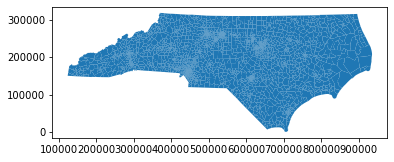

In [73]:
gdf.plot()

In [75]:
gdf['geometry'].isna().any()

False

In [76]:
gdf

,objectid,id,prec_id,enr_desc,county_nam,of_prec_id,county_id,blockid,st_areasha,st_perimet,geometry
0,1,1,0003,ALBEMARLE NUMBER 3,STANLY,None,84,None,4.323128e+07,40731.350779,"POLYGON ((501353.677 178235.458, 501326.512 17..."
1,2,2,0003,DREXEL 03,BURKE,None,12,None,1.083199e+08,49918.849040,"POLYGON ((372074.708 221553.271, 372077.123 22..."
2,3,22,0019,LINVILLE 01,BURKE,None,12,None,8.718055e+08,160866.952809,"POLYGON ((348092.062 224114.752, 348049.712 22..."
3,4,23,0019,RIDENHOUR,STANLY,None,84,None,8.992723e+08,125698.778851,"POLYGON ((484800.946 182206.711, 484812.120 18..."
4,5,71,007,007,MECKLENBURG,None,60,None,1.852384e+07,17915.436972,"POLYGON ((446820.325 159981.344, 446765.383 16..."
...,...,...,...,...,...,...,...,...,...,...,...
2658,2659,10136,GLD118,GOLDSTON,CHATHAM,None,19,None,2.578724e+09,286678.498949,"POLYGON ((586640.476 199186.510, 586637.836 19..."
2659,2660,10137,MON119,MONCURE,CHATHAM,None,19,None,2.317259e+09,309357.300937,"POLYGON ((591910.971 203450.739, 591911.489 20..."
2660,2661,10138,WM,WEST MOYOCK,CURRITUCK,None,27,None,1.134493e+09,160500.010788,"POLYGON ((862732.647 302036.702, 862720.292 30..."
2661,2662,10139,CO,COINJOCK,CURRITUCK,None,27,None,9.606002e+08,159781.759396,"POLYGON ((874730.995 293329.153, 874731.009 29..."
